In [1]:
from __future__ import division
import random
from operator import attrgetter

In [2]:
def random_genome(allow_childless=True, max_food_to_children=100):
    while True:
        yield (
            random.random(), random.random(), 
            random.random() if allow_childless else 0.0,
            random.random() * max_food_to_children
        )

In [3]:
def person_factory(max_children=10, mature_age=3, max_age=10, rand_child_chance=0.01):
    class Person(object):

        (PERCENT_TO_SELF,
         PERCENT_TO_CHILDREN,
         CHANCE_CHILDLESS_CHILD,
         INIT_TO_CHILDREN,) = range(4)

        def __init__(self, genome, food, childless):
            self.genome = genome
            self.childless = childless
            self.food = food
            self.children = []
            self.siblings = ()
            self.age = 0
            self.dead = False

        def step(self, food, population):
            # Death
            if self.dead:
                self.age += 1
                return
            
            elif self.age > max_age:
                self.dead = True
                self.age += 1
                return
            
            # Food
            if self.age < mature_age:
                self.food += food

            elif food > 0:
                to_self = food * self.genome[self.PERCENT_TO_SELF]
                to_children = (food - to_self) * self.genome[self.PERCENT_TO_CHILDREN]
                to_kin = (food - to_self - to_children)

                self.food += to_self
                
                living_children = [
                    child 
                    for child in self.children
                    if not child.dead
                    and child.age < mature_age
                ]
                if living_children:
                    num_children = len(living_children)
                    for child in living_children:
                        child.food += to_children / num_children
                else:
                    to_kin += to_children

                living_kin = [
                    sibling 
                    for sibling in self.siblings
                    if not sibling.dead
                ] + [
                    child 
                    for sibling in self.siblings 
                    for child in sibling.children
                    if not child.dead
                ] + [
                    grandchild
                    for sibling in self.siblings
                    for child in sibling.children
                    for grandchild in child.children
                    if not grandchild.dead
                ]
                if living_kin:
                    num_kin = len(living_kin)
                    for kin in living_kin:
                        kin.food += to_kin / num_kin
                else:
                    self.food += to_kin

            else:
                self.food += food

            # Food check
            if self.food <= 0:
                self.dead = True
                
            elif self.age == mature_age and not self.childless:
                # Select mate from population
                partner = random.choice([
                    person
                    for person in population
                    if not person.dead
                    and person.age == self.age
                    and person not in self.siblings
                ])  # Randomly select mate
                
                # Create children, deciding if childless
                init_to_children = self.genome[self.INIT_TO_CHILDREN]
                for i in xrange(max_children):
                    if self.food < init_to_children:
                        break
                    self.food -= init_to_children
                    child_genome = [
                        max(random.gauss(combination, combination * 0.1), 0)
                        for combination in
                        ((g1 + g2) / 2
                         for g1, g2 in
                         zip(self.genome, partner.genome)
                        )
                    ]
                    child_genome[:3] = [min(g, 1) for g in child_genome[:3]]  # first three are probabilities
                    if random.random() < rand_child_chance:
                        child_genome = next(random_genome())
                    child = Person(
                        genome=child_genome,
                        food=init_to_children,
                        childless=random.random() < self.genome[self.CHANCE_CHILDLESS_CHILD]
                    )
                    self.children.append(child)
                    population.append(child)
                    
                for child in self.children:
                    child.siblings = frozenset(
                        sibling
                        for sibling in self.children
                        if sibling is not child
                    )
                 
            self.age += 1
            
    return Person

In [4]:
Person = person_factory()

In [9]:
INITIAL_FOOD = 50
AVERGE_FOOD = 5
INITIAL_POPULATION_SIZE = 10
MAX_POP_SIZE = 500
ITERATIONS = 1000

genomes = random_genome(allow_childless=False)
population = [Person(next(genomes), 100, False) for __ in xrange(INITIAL_POPULATION_SIZE)]

average_childlessness = [0.0]
average_food = [INITIAL_FOOD]
population_size = [INITIAL_POPULATION_SIZE]
for iteration in xrange(ITERATIONS):
    for person in population:
        person.step(random.gauss(AVERGE_FOOD, AVERGE_FOOD / 2), population)
    living_pop = [person for person in population if not person.dead]
    num_living = len(living_pop)
    population_size.append(num_living)
    average_childlessness.append(sum(
        person.genome[Person.CHANCE_CHILDLESS_CHILD]
        for person in living_pop
    ) / num_living)
    average_food.append(sum(
        person.food
        for person in living_pop
    ) / num_living)
    if not (iteration + 1) % 10:
        print iteration + 1, num_living, average_childlessness[-1], average_food[-1]
    if num_living > MAX_POP_SIZE:
        least_fit = sorted(population, key=attrgetter('food'))[:num_living - MAX_POP_SIZE]
        for person in least_fit:
            person.dead = True
    for person in population[:]:
        if person.dead:
            population.remove(person)

10 101 0.0 36.1324919587
20 140 0.0147734517386 37.9511957634
30 298 0.121264970487 34.4426940563
40 696 0.0701379042024 29.4783565578
50 500 0.034748438081 41.8601805519
60 459 0.0187907467075 46.984821678
70 914 0.0283672078563 29.9048525447
80 500 0.03066500348 46.3805096885
90 471 0.0346286550325 49.7386300088
100 900 0.0293038245383 31.2156221404
110 500 0.0217497275625 46.7645049582
120 470 0.020599424206 52.051185623
130 893 0.0113124643695 33.1425936216
140 500 0.0132023526036 53.4083573758
150 470 0.0179481648434 57.9838466028
160 858 0.0420332138434 36.521921855
170 500 0.0452296795482 55.2935555851
180 457 0.0348759333279 57.6971957165
190 788 0.0263759788061 37.1862367361
200 500 0.0222017109811 52.2878622168
210 451 0.0267242006428 53.4632053145
220 869 0.0330597672532 31.958702847
230 500 0.040250219762 45.6005878461
240 466 0.0561975037912 47.776334445
250 902 0.0882695194263 29.7129208458
260 500 0.087078456024 46.4259964268
270 457 0.0657049251301 47.5735893439
280 860

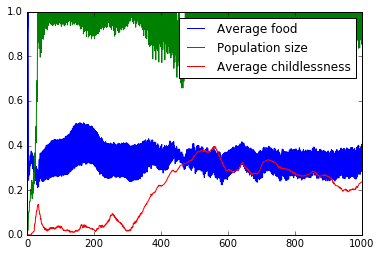

In [16]:
%matplotlib inline
from matplotlib import pyplot as pl
pl.plot([f / max(average_food) for f in average_food], label='Average food')
pl.plot([min(p, MAX_POP_SIZE) / MAX_POP_SIZE for p in population_size], label='Population size')
pl.plot(average_childlessness, label='Average childlessness')
pl.legend()
pl.show()

In [27]:
INITIAL_FOOD = 50
AVERGE_FOOD = 5
INITIAL_POPULATION_SIZE = 10
MAX_POP_SIZE = 500
ITERATIONS = 1000

genomes = random_genome(allow_childless=False)
population = [Person(next(genomes), 100, False) for __ in xrange(INITIAL_POPULATION_SIZE)]

average_childlessness = [0.0]
average_food = [INITIAL_FOOD]
population_size = [INITIAL_POPULATION_SIZE]
for iteration in xrange(ITERATIONS):
    for person in population:
        person.step(random.gauss(AVERGE_FOOD, AVERGE_FOOD / 2), population)
    living_pop = [person for person in population if not person.dead]
    if not living_pop:
        print 'All dead!'
        break
    num_living = len(living_pop)
    population_size.append(num_living)
    average_childlessness.append(sum(
        person.genome[Person.CHANCE_CHILDLESS_CHILD]
        for person in living_pop
    ) / num_living)
    average_food.append(sum(
        person.food
        for person in living_pop
    ) / num_living)
    if not (iteration + 1) % 25:
        print iteration + 1, num_living, average_childlessness[-1], average_food[-1]
    if num_living > MAX_POP_SIZE:
        least_fit = sorted(population, key=attrgetter('food'))[:num_living - MAX_POP_SIZE]
        for person in least_fit:
            person.dead = True
    for person in population[:]:
        if person.dead:
            population.remove(person)

25 91 0.00170484019465 41.441344551
50 81 0.00804237341925 53.5249815715
75 42 5.04267304851e-05 67.1818988052
100 29 1.43403846169e-07 61.2114308668
125 26 0.0321021074303 62.5953731005
150 16 0.0 47.5309970441
175 16 0.0369638898758 41.1171922628
200 20 0.0196333949754 42.9039198571
225 31 0.143000869778 38.5580091436
250 304 0.0563991256023 24.1210800424
275 500 0.0731252111352 41.3355294405
300 466 0.0769474296635 45.2317924466
325 800 0.0969762540976 31.7272268599
350 500 0.115079348125 47.4974017969
375 430 0.139043150705 47.3372352418
400 839 0.102246503115 28.79314274
425 500 0.0951480723287 42.70892264
450 450 0.118953995151 45.9802308591
475 771 0.142088863572 31.9377267868
500 500 0.145716387835 43.225074447
525 457 0.115151866399 44.9000185102
550 855 0.126245280113 28.9472652056
575 500 0.100615406849 44.7518621759
600 453 0.105947717285 43.7486814664
625 775 0.106437410796 32.6484903854
650 500 0.0969345481713 45.814661573
675 433 0.114888189463 49.1189810013
700 843 0.08

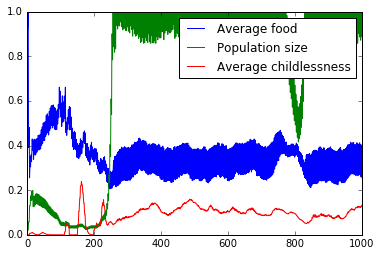

In [28]:
%matplotlib inline
from matplotlib import pyplot as pl
pl.plot([f / max(average_food) for f in average_food], label='Average food')
pl.plot([min(p, MAX_POP_SIZE) / MAX_POP_SIZE for p in population_size], label='Population size')
pl.plot(average_childlessness, label='Average childlessness')
pl.legend()
pl.show()

In [31]:
INITIAL_FOOD = 50
AVERGE_FOOD = 5
INITIAL_POPULATION_SIZE = 10
MAX_POP_SIZE = 500
ITERATIONS = 1000

genomes = random_genome(allow_childless=False)
population = [Person(next(genomes), 100, False) for __ in xrange(INITIAL_POPULATION_SIZE)]

average_childlessness = [0.0]
average_food = [INITIAL_FOOD]
population_size = [INITIAL_POPULATION_SIZE]
for iteration in xrange(ITERATIONS):
    for person in population:
        person.step(random.gauss(AVERGE_FOOD, AVERGE_FOOD / 2), population)
    living_pop = [person for person in population if not person.dead]
    if not living_pop:
        print 'All dead!'
        break
    num_living = len(living_pop)
    population_size.append(num_living)
    average_childlessness.append(sum(
        person.genome[Person.CHANCE_CHILDLESS_CHILD]
        for person in living_pop
    ) / num_living)
    average_food.append(sum(
        person.food
        for person in living_pop
    ) / num_living)
    if not (iteration + 1) % 25:
        print iteration + 1, num_living, average_childlessness[-1], average_food[-1]
    if num_living > MAX_POP_SIZE:
        least_fit = sorted(population, key=attrgetter('food'))[:num_living - MAX_POP_SIZE]
        for person in least_fit:
            person.dead = True
    for person in population[:]:
        if person.dead:
            population.remove(person)

25 25 0.0 49.8579678675
50 12 0.0 56.7308948431
75 9 0.00864219679489 59.2233707663
100 8 0.000845764451778 49.6798618965
125 8 3.91332314404e-05 52.762627469
150 3 0.0 51.3531824879
175 4 0.0 43.4178428159
200 4 0.0 39.7667111393
225 12 0.0 33.9967639137
250 1088 0.00365073696914 18.9533004056
275 500 0.0283845811675 34.8404281355
300 480 0.0378118854589 41.0108696888
325 1018 0.0310527301969 25.1805885779
350 500 0.0241200331855 39.0556950864
375 484 0.0217132137917 43.7254059426
400 1022 0.0215870272491 25.489689489
425 500 0.0416047172159 40.6367618076
450 478 0.0238915215576 43.1204140557
475 967 0.0278474967254 27.5155067847
500 500 0.0480675183488 42.5148148546
525 473 0.022540153933 47.1465758708
550 981 0.0144954817529 27.6274933101
575 500 0.0741811199959 44.7705017461
600 433 0.139616295584 52.0186159092
625 573 0.145579141778 36.4174261907
650 500 0.132600914311 44.6054738936
675 439 0.114069019762 44.892390171
700 854 0.107914704853 28.9989579879
725 500 0.0882389524306 43

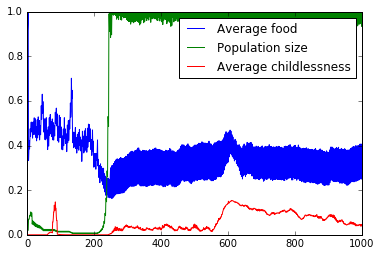

In [32]:
%matplotlib inline
from matplotlib import pyplot as pl
pl.plot([f / max(average_food) for f in average_food], label='Average food')
pl.plot([min(p, MAX_POP_SIZE) / MAX_POP_SIZE for p in population_size], label='Population size')
pl.plot(average_childlessness, label='Average childlessness')
pl.legend()
pl.show()

In [35]:
import math
[math.sin(x / 2) for x in xrange(20)]

[0.0,
 0.479425538604203,
 0.8414709848078965,
 0.9974949866040544,
 0.9092974268256817,
 0.5984721441039565,
 0.1411200080598672,
 -0.35078322768961984,
 -0.7568024953079282,
 -0.977530117665097,
 -0.9589242746631385,
 -0.7055403255703919,
 -0.27941549819892586,
 0.21511998808781552,
 0.6569865987187891,
 0.9379999767747389,
 0.9893582466233818,
 0.7984871126234903,
 0.4121184852417566,
 -0.0751511204618093]

In [36]:
INITIAL_FOOD = 50
AVERGE_FOOD = 5
INITIAL_POPULATION_SIZE = 10
MAX_POP_SIZE = 500
ITERATIONS = 1000

genomes = random_genome(allow_childless=False)
population = [Person(next(genomes), 100, False) for __ in xrange(INITIAL_POPULATION_SIZE)]

average_childlessness = [0.0]
average_food = [INITIAL_FOOD]
population_size = [INITIAL_POPULATION_SIZE]
for iteration in xrange(ITERATIONS):
    for person in population:
        person.step(random.gauss(AVERGE_FOOD, AVERGE_FOOD / 2), population)
    living_pop = [person for person in population if not person.dead]
    if not living_pop:
        print 'All dead!'
        break
    num_living = len(living_pop)
    population_size.append(num_living)
    average_childlessness.append(sum(
        person.genome[Person.CHANCE_CHILDLESS_CHILD]
        for person in living_pop
    ) / num_living)
    average_food.append(sum(
        person.food
        for person in living_pop
    ) / num_living)
    if not (iteration + 1) % 25:
        print iteration + 1, num_living, average_childlessness[-1], average_food[-1]
    if num_living > MAX_POP_SIZE:
        least_fit = sorted(population, key=attrgetter('food'))[:num_living - MAX_POP_SIZE]
        for person in least_fit:
            person.dead = True
    for person in population[:]:
        if person.dead:
            population.remove(person)

25 102 0.0297980689177 47.8222383588
50 500 0.240549635894 29.4925647538
75 423 0.276818067015 34.7047329261
100 877 0.258508376321 23.7074704413
125 500 0.22642942188 39.8904875831
150 433 0.242623706201 41.8387620367
175 756 0.253040333438 29.659889775
200 500 0.300224067335 43.897299927
225 417 0.324818326613 45.6655631066
250 648 0.319065018522 33.5132043808
275 500 0.331243293213 45.2472655131
300 418 0.317078964988 41.8324203029
325 729 0.342898218945 28.6041750174
350 500 0.330552017653 41.8416224187
375 417 0.297957545224 40.4857676951
400 757 0.286214096008 27.4975079351
425 500 0.309432492817 40.8826631577
450 434 0.257398629871 43.4402159689
475 733 0.219720407251 30.4889188963
500 500 0.230982315282 45.97240569
525 378 0.200777506409 42.9983343523
550 597 0.177995592903 33.5858611739
575 500 0.202155707223 45.2119152552
600 435 0.155017593174 45.4431410195
625 760 0.166227336067 31.4512459396
650 500 0.182565149922 47.2244386373
675 345 0.1797388362 44.7524810447
700 143 0.

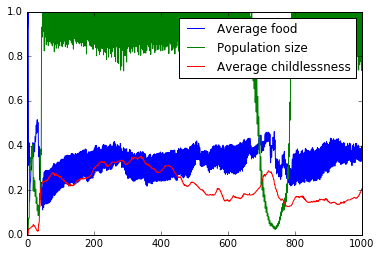

In [37]:
%matplotlib inline
from matplotlib import pyplot as pl
pl.plot([f / max(average_food) for f in average_food], label='Average food')
pl.plot([min(p, MAX_POP_SIZE) / MAX_POP_SIZE for p in population_size], label='Population size')
pl.plot(average_childlessness, label='Average childlessness')
pl.legend()
pl.show()

In [40]:
INITIAL_FOOD = 50
AVERGE_FOOD = 5
INITIAL_POPULATION_SIZE = 10
MAX_POP_SIZE = 500
ITERATIONS = 1000

genomes = random_genome(allow_childless=False)
population = [Person(next(genomes), 100, False) for __ in xrange(INITIAL_POPULATION_SIZE)]

average_childlessness = [0.0]
average_food = [INITIAL_FOOD]
population_size = [INITIAL_POPULATION_SIZE]
average_init_to_children = [sum(p.genome[Person.INIT_TO_CHILDREN] for p in population) / INITIAL_POPULATION_SIZE]
for iteration in xrange(ITERATIONS):
    for person in population:
        person.step(random.gauss(AVERGE_FOOD, AVERGE_FOOD / 2), population)
    living_pop = [person for person in population if not person.dead]
    if not living_pop:
        print 'All dead!'
        break
    num_living = len(living_pop)
    population_size.append(num_living)
    average_childlessness.append(sum(
        person.genome[Person.CHANCE_CHILDLESS_CHILD]
        for person in living_pop
    ) / num_living)
    average_food.append(sum(
        person.food
        for person in living_pop
    ) / num_living)
    average_init_to_children.append(sum(
        person.genome[Person.INIT_TO_CHILDREN] 
        for person in living_pop
    ) / num_living)
    if not (iteration + 1) % 25:
        print iteration + 1, num_living, average_childlessness[-1], average_food[-1]
    if num_living > MAX_POP_SIZE:
        least_fit = sorted(population, key=attrgetter('food'))[:num_living - MAX_POP_SIZE]
        for person in least_fit:
            person.dead = True
    for person in population[:]:
        if person.dead:
            population.remove(person)

25 1885 0.0304541770791 12.3689203783
50 500 0.0740678258107 28.6370552314
75 465 0.0870935028687 33.5459688808
100 1145 0.10501056324 19.414176071
125 500 0.163797435414 39.9448172162
150 443 0.171525950625 43.5319122027
175 682 0.191901487284 34.9051752071
200 500 0.243807734707 47.3971084675
225 407 0.237691510086 44.732129666
250 828 0.196037478746 27.6297417133
275 500 0.191242062392 41.1804904379
300 419 0.246235202562 42.5579986963
325 759 0.217738790708 29.2096816071
350 500 0.181966144649 42.8782301889
375 442 0.115726908415 40.6096066287
400 922 0.0880875263355 26.4306426653
425 500 0.14961131684 41.8105884437
450 432 0.173660563671 47.2894086286
475 811 0.15724068465 30.131257114
500 500 0.174417984334 45.746224232
525 405 0.188847588946 48.6263564754
550 756 0.179220462072 30.702651554
575 500 0.185513674556 45.4561803911
600 431 0.195355917516 46.1955465016
625 781 0.21049234424 29.6373539203
650 500 0.223471044766 47.0167710394
675 416 0.215862023578 45.4323149943
700 693

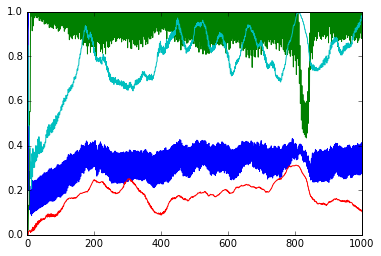

In [43]:
%matplotlib inline
from matplotlib import pyplot as pl
pl.plot([f / max(average_food) for f in average_food], label='Average food')
pl.plot([min(p, MAX_POP_SIZE) / MAX_POP_SIZE for p in population_size], label='Population size')
pl.plot(average_childlessness, label='Average childlessness')
pl.plot([f / max(average_init_to_children) for f in average_init_to_children], label='Average child start food')
#pl.legend()
pl.show()

In [61]:
INITIAL_FOOD = 50
AVERAGE_FOOD = 1
INITIAL_POPULATION_SIZE = 50
MAX_POP_SIZE = 500
ITERATIONS = 1000

genomes = random_genome(allow_childless=False)
population = [Person(next(genomes), 100, False) for __ in xrange(INITIAL_POPULATION_SIZE)]

average_childlessness = [0.0]
average_food = [INITIAL_FOOD]
population_size = [INITIAL_POPULATION_SIZE]
average_init_to_children = [sum(p.genome[Person.INIT_TO_CHILDREN] for p in population) / INITIAL_POPULATION_SIZE]
for iteration in xrange(ITERATIONS):
    for person in population:
        person.step(random.gauss(AVERAGE_FOOD, 1), population)
    living_pop = [person for person in population if not person.dead]
    if not living_pop:
        print 'All dead!'
        break
    num_living = len(living_pop)
    population_size.append(num_living)
    average_childlessness.append(sum(
        person.genome[Person.CHANCE_CHILDLESS_CHILD]
        for person in living_pop
    ) / num_living)
    average_food.append(sum(
        person.food
        for person in living_pop
    ) / num_living)
    average_init_to_children.append(sum(
        person.genome[Person.INIT_TO_CHILDREN] 
        for person in living_pop
    ) / num_living)
    if not (iteration + 1) % 25:
        print iteration + 1, num_living, average_childlessness[-1], average_food[-1]
    if num_living > MAX_POP_SIZE:
        least_fit = sorted(population, key=attrgetter('food'))[:num_living - MAX_POP_SIZE]
        for person in least_fit:
            person.dead = True
    for person in population[:]:
        if person.dead:
            population.remove(person)

25 95 0.0419271851309 14.4609451457
50 32 0.00676166503672 10.1249205542
75 55 0.0127089889421 8.39170041668
100 119 7.59681317762e-05 7.32689797988
125 145 0.0036379132218 7.84669741526
150 227 0.0155285916666 8.50310655126
175 633 0.0038642994582 6.67270852122
200 500 0.0222390831725 9.53194722794
225 459 0.0287139839377 9.96373544016
250 905 0.0308771138632 5.95651383111
275 500 0.0367942355875 8.60239632854
300 468 0.0134707879495 8.81517063945
325 1095 0.0138539088149 4.88518814617
350 500 0.0207116205275 8.40925052755
375 456 0.00756888278439 9.7974254455
400 871 0.0161727954813 6.34855938697
425 500 0.0202532254615 9.91924170102
450 446 0.0433350589697 10.8107475909
475 857 0.033920280106 6.17366298905
500 500 0.0156857520994 8.61723919425
525 459 0.0464991595526 9.49669439962
550 1076 0.00969087455033 4.87861510132
575 500 0.0321563757318 8.48124808241
600 477 0.028608273039 8.60707816239
625 1091 0.0170066433056 4.62609922128
650 500 0.0143847724057 7.13731790853
675 462 0.032

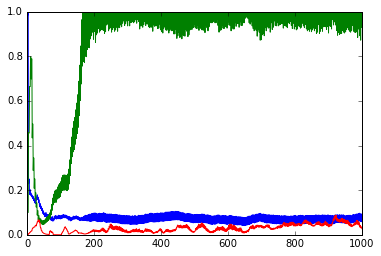

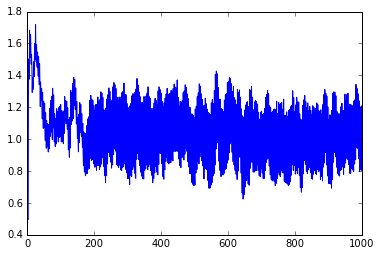

In [66]:
%matplotlib inline
from matplotlib import pyplot as pl
pl.plot([f / max(average_food) for f in average_food], label='Average food')
pl.plot([min(p, MAX_POP_SIZE) / MAX_POP_SIZE for p in population_size], label='Population size')
pl.plot(average_childlessness, label='Average childlessness')
#pl.legend()
pl.show()
pl.plot([f / av for f, av in zip(average_init_to_children, average_food)], label='Average child start food')
pl.show()

In [73]:
INITIAL_FOOD = 50
AVERAGE_FOOD = 1
INITIAL_POPULATION_SIZE = 50
MAX_POP_SIZE = 500
ITERATIONS = 1000

genomes = random_genome(allow_childless=False)
population = [Person(next(genomes), 100, False) for __ in xrange(INITIAL_POPULATION_SIZE)]

average_childlessness = [0.0]
average_food = [INITIAL_FOOD]
population_size = [INITIAL_POPULATION_SIZE]
average_init_to_children = [sum(p.genome[Person.INIT_TO_CHILDREN] for p in population) / INITIAL_POPULATION_SIZE]
for iteration in xrange(ITERATIONS):
    for person in population:
        person.step(random.gauss(AVERAGE_FOOD, 1), population)
    living_pop = [person for person in population if not person.dead]
    if not living_pop:
        print 'All dead!'
        break
    num_living = len(living_pop)
    population_size.append(num_living)
    average_childlessness.append(sum(
        person.genome[Person.CHANCE_CHILDLESS_CHILD]
        for person in living_pop
    ) / num_living)
    average_food.append(sum(
        person.food
        for person in living_pop
    ) / num_living)
    average_init_to_children.append(sum(
        person.genome[Person.INIT_TO_CHILDREN] 
        for person in living_pop
    ) / num_living)
    if not (iteration + 1) % 25:
        print iteration + 1, num_living, average_childlessness[-1], average_food[-1]
    if num_living > MAX_POP_SIZE:
        least_fit = sorted(population, key=attrgetter('food'))[:num_living - MAX_POP_SIZE]
        for person in least_fit:
            person.dead = True
    for person in population[:]:
        if person.dead:
            population.remove(person)

25 63 0.000136372216741 18.0368158807
50 40 0.0 10.461734142
75 26 0.0150882912063 10.5160395291
100 87 0.180277465241 4.52078882502
125 565 0.261825787699 6.5312814968
150 418 0.255113590876 6.98600106315
175 1668 0.226261228429 2.74247316408
200 526 0.258115711485 7.08906024719
225 419 0.317572408306 7.41541393331
250 1275 0.350929515221 3.47624305683
275 506 0.350105908352 7.47690814594
300 405 0.388755249609 7.81268184077
325 1096 0.279305422813 3.97539274442
350 504 0.236505378487 7.08283689145
375 442 0.173783649864 7.29535807353
400 1111 0.16263705296 3.76588073862
425 500 0.208517214561 7.27778498246
450 414 0.252872330742 8.14073590307
475 871 0.228937216068 5.04367077275
500 500 0.174756598476 8.08686289556
525 449 0.139139385874 8.65819706528
550 1067 0.114271315161 4.4361956244
575 500 0.138734706794 7.73215689708
600 432 0.161237956456 9.12677828681
625 757 0.139983927873 6.31166972088
650 500 0.142381865171 9.90069922357
675 426 0.14099906652 9.94588533599
700 709 0.09281

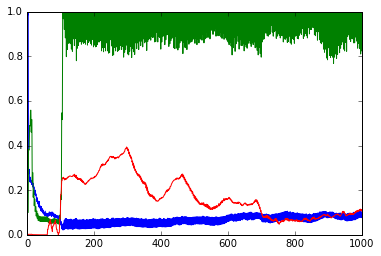

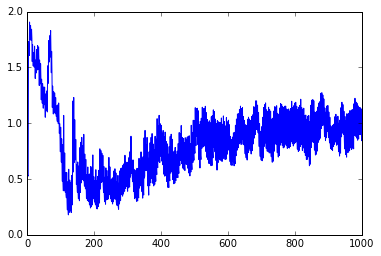

In [75]:
%matplotlib inline
from matplotlib import pyplot as pl
pl.plot([f / max(average_food) for f in average_food], label='Average food')
pl.plot([min(p, MAX_POP_SIZE) / MAX_POP_SIZE for p in population_size], label='Population size')
pl.plot(average_childlessness, label='Average childlessness')
#pl.legend()
pl.show()
pl.plot([f / av for f, av in zip(average_init_to_children, average_food)], label='Average child start food')
pl.show()

In [77]:
INITIAL_FOOD = 50
AVERAGE_FOOD = 1
INITIAL_POPULATION_SIZE = 50
MAX_POP_SIZE = 500
ITERATIONS = 1000

genomes = random_genome(allow_childless=False)
population = [Person(next(genomes), 100, False) for __ in xrange(INITIAL_POPULATION_SIZE)]

average_childlessness = [0.0]
average_food = [INITIAL_FOOD]
population_size = [INITIAL_POPULATION_SIZE]
average_init_to_children = [sum(p.genome[Person.INIT_TO_CHILDREN] for p in population) / INITIAL_POPULATION_SIZE]
for iteration in xrange(ITERATIONS):
    for person in population:
        person.step(random.gauss(AVERAGE_FOOD, 1), population)
    living_pop = [person for person in population if not person.dead]
    if not living_pop:
        print 'All dead!'
        break
    num_living = len(living_pop)
    population_size.append(num_living)
    average_childlessness.append(sum(
        person.genome[Person.CHANCE_CHILDLESS_CHILD]
        for person in living_pop
    ) / num_living)
    average_food.append(sum(
        person.food
        for person in living_pop
    ) / num_living)
    average_init_to_children.append(sum(
        person.genome[Person.INIT_TO_CHILDREN] 
        for person in living_pop
    ) / num_living)
    if not (iteration + 1) % 25:
        print iteration + 1, num_living, average_childlessness[-1], average_food[-1]
    if num_living > MAX_POP_SIZE:
        least_fit = sorted(population, key=attrgetter('food'))[:num_living - MAX_POP_SIZE]
        for person in least_fit:
            person.dead = True
    for person in population[:]:
        if person.dead:
            population.remove(person)

25 388 0.00607628766819 6.7187648341
50 500 0.0410587936396 7.46530960867
75 475 0.0411714618922 8.13493241401
100 1119 0.0308350748815 4.46783964904
125 500 0.03996923825 8.13104046842
150 481 0.028966241067 8.74835316078
175 980 0.0209677961354 5.33430492809
200 500 0.037067777374 9.4658576637
225 449 0.0376703599788 10.4838171118
250 716 0.0583043114452 7.91232974762
275 500 0.0498492054721 10.4848257309
300 375 0.0243579286277 9.18845664736
325 1064 0.01598831265 4.83200637927
350 500 0.038181462419 8.18277189758
375 479 0.0229122674873 8.71953248677
400 1054 0.017812022383 4.8277765406
425 500 0.0127686741702 7.93307857192
450 474 0.0154173004762 9.51054536798
475 962 0.0131839140961 5.73286015588
500 500 0.115514790474 10.6983519967
525 302 0.215758236845 9.57104927325
550 86 0.236159323423 8.71715220707
575 11 0.198859582976 7.04059911021
600 2 0.228383845043 14.3896271908
All dead!


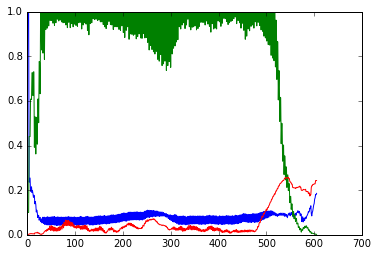

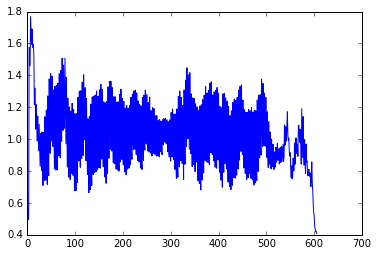

In [79]:
%matplotlib inline
from matplotlib import pyplot as pl
pl.plot([f / max(average_food) for f in average_food], label='Average food')
pl.plot([min(p, MAX_POP_SIZE) / MAX_POP_SIZE for p in population_size], label='Population size')
pl.plot(average_childlessness, label='Average childlessness')
#pl.legend()
pl.show()
pl.plot([f / av for f, av in zip(average_init_to_children, average_food)], label='Average child start food')
pl.show()

In [80]:
INITIAL_FOOD = 50
AVERAGE_FOOD = 1
INITIAL_POPULATION_SIZE = 50
MAX_POP_SIZE = 500
ITERATIONS = 1000

genomes = random_genome(allow_childless=False)
population = [Person(next(genomes), 100, False) for __ in xrange(INITIAL_POPULATION_SIZE)]

average_childlessness = [0.0]
average_food = [INITIAL_FOOD]
population_size = [INITIAL_POPULATION_SIZE]
average_init_to_children = [sum(p.genome[Person.INIT_TO_CHILDREN] for p in population) / INITIAL_POPULATION_SIZE]
for iteration in xrange(ITERATIONS):
    for person in population:
        person.step(random.gauss(AVERAGE_FOOD, 1), population)
    living_pop = [person for person in population if not person.dead]
    if not living_pop:
        print 'All dead!'
        break
    num_living = len(living_pop)
    population_size.append(num_living)
    average_childlessness.append(sum(
        person.genome[Person.CHANCE_CHILDLESS_CHILD]
        for person in living_pop
    ) / num_living)
    average_food.append(sum(
        person.food
        for person in living_pop
    ) / num_living)
    average_init_to_children.append(sum(
        person.genome[Person.INIT_TO_CHILDREN] 
        for person in living_pop
    ) / num_living)
    if not (iteration + 1) % 25:
        print iteration + 1, num_living, average_childlessness[-1], average_food[-1]
    if num_living > MAX_POP_SIZE:
        least_fit = sorted(population, key=attrgetter('food'))[:num_living - MAX_POP_SIZE]
        for person in least_fit:
            person.dead = True
    for person in population[:]:
        if person.dead:
            population.remove(person)

25 1004 0.00985843482648 4.49843069024
50 500 0.0343489991116 7.00662060385
75 486 0.0217638467761 8.01922149621
100 1084 0.018008451998 4.63960794895
125 500 0.0404026561502 8.13688142056
150 447 0.0868832369189 10.1147138933
175 750 0.136997737293 6.66162152407
200 500 0.162323872098 8.86523714998
225 438 0.180969555251 8.96324599833
250 753 0.197851858188 6.31959433541
275 500 0.200494061336 9.40368788011
300 398 0.234836323558 9.83761055285
325 407 0.241185197373 8.78719716563
350 140 0.263209639964 10.4358616821
375 30 0.227926053009 10.0358655595
400 15 0.203664351579 8.96950109019
425 10 0.207877023033 8.44751738186
450 3 0.249699178461 10.5202319425
All dead!


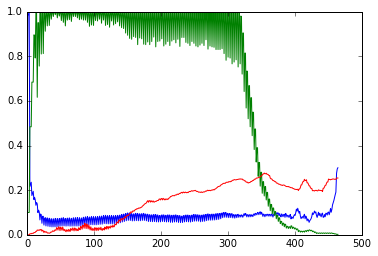

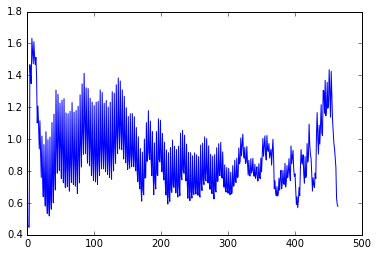

In [81]:
%matplotlib inline
from matplotlib import pyplot as pl
pl.plot([f / max(average_food) for f in average_food], label='Average food')
pl.plot([min(p, MAX_POP_SIZE) / MAX_POP_SIZE for p in population_size], label='Population size')
pl.plot(average_childlessness, label='Average childlessness')
#pl.legend()
pl.show()
pl.plot([f / av for f, av in zip(average_init_to_children, average_food)], label='Average child start food')
pl.show()

In [83]:
INITIAL_FOOD = 50
AVERAGE_FOOD = 1
INITIAL_POPULATION_SIZE = 50
MAX_POP_SIZE = 500
ITERATIONS = 1000

genomes = random_genome(allow_childless=False)
population = [Person(next(genomes), 100, False) for __ in xrange(INITIAL_POPULATION_SIZE)]

average_childlessness = [0.0]
average_food = [INITIAL_FOOD]
population_size = [INITIAL_POPULATION_SIZE]
average_init_to_children = [sum(p.genome[Person.INIT_TO_CHILDREN] for p in population) / INITIAL_POPULATION_SIZE]
for iteration in xrange(ITERATIONS):
    for person in population:
        person.step(random.gauss(AVERAGE_FOOD, 1), population)
    living_pop = [person for person in population if not person.dead]
    if not living_pop:
        print 'All dead!'
        break
    num_living = len(living_pop)
    population_size.append(num_living)
    average_childlessness.append(sum(
        person.genome[Person.CHANCE_CHILDLESS_CHILD]
        for person in living_pop
    ) / num_living)
    average_food.append(sum(
        person.food
        for person in living_pop
    ) / num_living)
    average_init_to_children.append(sum(
        person.genome[Person.INIT_TO_CHILDREN] 
        for person in living_pop
    ) / num_living)
    if not (iteration + 1) % 25:
        print iteration + 1, num_living, average_childlessness[-1], average_food[-1]
    if num_living > MAX_POP_SIZE:
        least_fit = sorted(population, key=attrgetter('food'))[:num_living - MAX_POP_SIZE]
        for person in least_fit:
            person.dead = True
    for person in population[:]:
        if person.dead:
            population.remove(person)

25 102 0.0101715702156 15.3048114626
50 44 0.0533272866465 9.85855588653
75 5 0.0 11.0789228045
100 18 0.0 6.10618646093
125 147 0.00522173681104 6.30964921419
150 463 0.0262375392104 8.58039291575
175 894 0.0290267704324 5.7763537707
200 500 0.0361036133555 8.69576190244
225 474 0.0217383382543 9.11530279027
250 901 0.0344492708161 5.67303375325
275 500 0.0560091357651 9.14053214144
300 460 0.0478702888451 9.74287218302
325 701 0.152519022449 6.93177949855
350 500 0.18148157756 9.58185026124
375 204 0.182772137322 10.3290623995
400 53 0.181483093633 10.1550126072
425 15 0.100785013436 9.99964101967
450 37 0.201810198736 8.14542006492
475 482 0.167405833636 5.10874505223
500 500 0.121392334245 8.45253099167
525 451 0.098097102804 8.34980754271
550 1018 0.0912593397242 4.72438224643
575 500 0.0806498378971 7.59500530263
600 453 0.0800188894755 9.3400383156
625 705 0.0853398192437 7.11330686527
650 500 0.11384203524 9.29237206579
675 390 0.124828469873 9.45945875446
700 831 0.09425932012

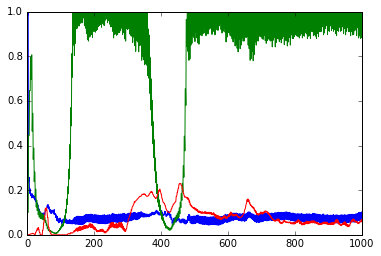

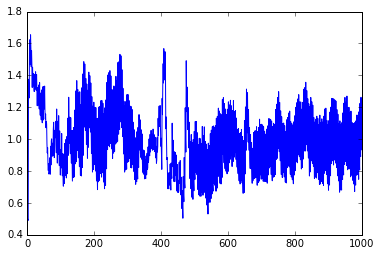

In [85]:
%matplotlib inline
from matplotlib import pyplot as pl
pl.plot([f / max(average_food) for f in average_food], label='Average food')
pl.plot([min(p, MAX_POP_SIZE) / MAX_POP_SIZE for p in population_size], label='Population size')
pl.plot(average_childlessness, label='Average childlessness')
#pl.legend()
pl.show()
pl.plot([f / av for f, av in zip(average_init_to_children, average_food)], label='Average child start food')
pl.show()

In [87]:
INITIAL_FOOD = 10
AVERAGE_FOOD = 1
INITIAL_POPULATION_SIZE = 50
MAX_POP_SIZE = 500
ITERATIONS = 1000

genomes = random_genome(allow_childless=False)
population = [Person(next(genomes), 100, False) for __ in xrange(INITIAL_POPULATION_SIZE)]

average_childlessness = [0.0]
average_food = [INITIAL_FOOD]
population_size = [INITIAL_POPULATION_SIZE]
average_init_to_children = [sum(p.genome[Person.INIT_TO_CHILDREN] for p in population) / INITIAL_POPULATION_SIZE]
for iteration in xrange(ITERATIONS):
    for person in population:
        person.step(random.gauss(AVERAGE_FOOD, 1), population)
    living_pop = [person for person in population if not person.dead]
    if not living_pop:
        print 'All dead!'
        break
    num_living = len(living_pop)
    population_size.append(num_living)
    average_childlessness.append(sum(
        person.genome[Person.CHANCE_CHILDLESS_CHILD]
        for person in living_pop
    ) / num_living)
    average_food.append(sum(
        person.food
        for person in living_pop
    ) / num_living)
    average_init_to_children.append(sum(
        person.genome[Person.INIT_TO_CHILDREN] 
        for person in living_pop
    ) / num_living)
    if not (iteration + 1) % 25:
        print iteration + 1, num_living, average_childlessness[-1], average_food[-1]
    if num_living > MAX_POP_SIZE:
        least_fit = sorted(population, key=attrgetter('food'))[:num_living - MAX_POP_SIZE]
        for person in least_fit:
            person.dead = True
    for person in population[:]:
        if person.dead:
            population.remove(person)

25 190 0.00670101938406 8.1755724194
50 500 0.00649603239668 7.95185507189
75 431 0.0221913919604 10.2101272738
100 642 0.0304924130419 8.47606492522
125 500 0.019410836565 9.89466045392
150 325 0.0334948579022 9.67826151015
175 256 0.0174620805966 8.39589103843
200 158 0.0249949980375 10.0687149159
225 61 0.018812297808 10.7328629653
250 43 0.0780320979815 9.73685186824
275 11 0.00771549969771 10.8173657627
300 3 0.00550925309913 11.9486138235
325 11 0.838234767942 9.20816140125
All dead!


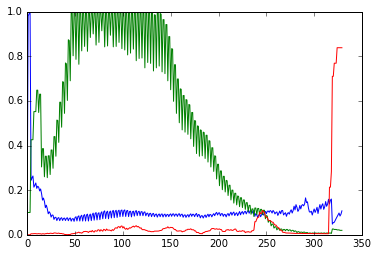

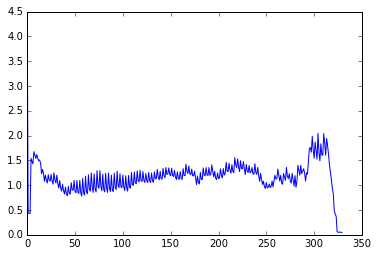

In [88]:
%matplotlib inline
from matplotlib import pyplot as pl
pl.plot([f / max(average_food) for f in average_food], label='Average food')
pl.plot([min(p, MAX_POP_SIZE) / MAX_POP_SIZE for p in population_size], label='Population size')
pl.plot(average_childlessness, label='Average childlessness')
#pl.legend()
pl.show()
pl.plot([f / av for f, av in zip(average_init_to_children, average_food)], label='Average child start food')
pl.show()

In [94]:
INITIAL_FOOD = 10
AVERAGE_FOOD = 1
INITIAL_POPULATION_SIZE = 50
MAX_POP_SIZE = 500
ITERATIONS = 1000

genomes = random_genome(allow_childless=False)
population = [Person(next(genomes), 100, False) for __ in xrange(INITIAL_POPULATION_SIZE)]

average_childlessness = [0.0]
average_food = [INITIAL_FOOD]
population_size = [INITIAL_POPULATION_SIZE]
average_init_to_children = [sum(p.genome[Person.INIT_TO_CHILDREN] for p in population) / INITIAL_POPULATION_SIZE]
for iteration in xrange(ITERATIONS):
    for person in population:
        person.step(random.gauss(AVERAGE_FOOD, 1), population)
    living_pop = [person for person in population if not person.dead]
    if not living_pop:
        print 'All dead!'
        break
    num_living = len(living_pop)
    population_size.append(num_living)
    average_childlessness.append(sum(
        person.genome[Person.CHANCE_CHILDLESS_CHILD]
        for person in living_pop
    ) / num_living)
    average_food.append(sum(
        person.food
        for person in living_pop
    ) / num_living)
    average_init_to_children.append(sum(
        person.genome[Person.INIT_TO_CHILDREN] 
        for person in living_pop
    ) / num_living)
    if not (iteration + 1) % 25:
        print iteration + 1, num_living, average_childlessness[-1], average_food[-1]
    if num_living > MAX_POP_SIZE:
        least_fit = sorted(population, key=attrgetter('food'))[:num_living - MAX_POP_SIZE]
        for person in least_fit:
            person.dead = True
    for person in population[:]:
        if person.dead:
            population.remove(person)

25 316 0.0198678674103 8.67010154298
50 500 0.0132663144091 8.68854103849
75 438 0.0151124870783 9.57474121233
100 791 0.0184978266645 6.65911181042
125 500 0.0255643215892 10.5050095881
150 427 0.00613895950358 10.972129245
175 704 0.0295404154824 7.15069873426
200 500 0.0137161857459 8.65458090603
225 476 0.0238808553006 8.92037756843
250 837 0.0334281007739 5.92600988096
275 500 0.024861366313 7.88777841332
300 456 0.0310724501452 9.75773507273
325 882 0.0197402967032 6.10501594931
350 500 0.0584187838288 9.83801718145
375 439 0.0503963579331 9.84284021778
400 850 0.025108380192 6.14662240149
425 500 0.0227027139003 9.69039239172
450 457 0.0162647809389 10.6848395184
475 758 0.0359055886143 7.08740884985
500 500 0.074484045448 10.4718729917
525 417 0.0856873530257 9.90637860756
550 666 0.0888621631997 7.31932907121
575 500 0.0817218653438 9.47018910319
600 444 0.0687614849863 9.14512213087
625 853 0.0617817523328 5.974137785
650 500 0.0571645501997 9.7345856412
675 431 0.04413955523

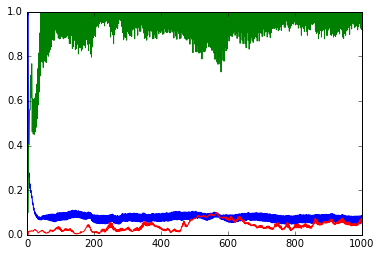

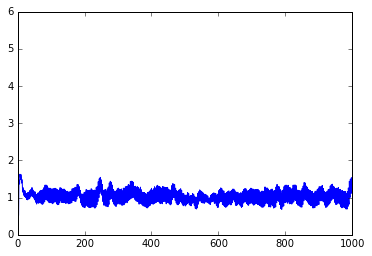

In [96]:
%matplotlib inline
from matplotlib import pyplot as pl
pl.plot([f / max(average_food) for f in average_food], label='Average food')
pl.plot([min(p, MAX_POP_SIZE) / MAX_POP_SIZE for p in population_size], label='Population size')
pl.plot(average_childlessness, label='Average childlessness')
#pl.legend()
pl.show()
pl.plot([f / av for f, av in zip(average_init_to_children, average_food)], label='Average child start food')
pl.show()

In [97]:
INITIAL_FOOD = 10
AVERAGE_FOOD = 1
INITIAL_POPULATION_SIZE = 50
MAX_POP_SIZE = 500
ITERATIONS = 1000

genomes = random_genome(allow_childless=False)
population = [Person(next(genomes), 100, False) for __ in xrange(INITIAL_POPULATION_SIZE)]

average_childlessness = [0.0]
average_food = [INITIAL_FOOD]
population_size = [INITIAL_POPULATION_SIZE]
average_init_to_children = [sum(p.genome[Person.INIT_TO_CHILDREN] for p in population) / INITIAL_POPULATION_SIZE]
for iteration in xrange(ITERATIONS):
    for person in population:
        person.step(random.gauss(AVERAGE_FOOD, 1), population)
    living_pop = [person for person in population if not person.dead]
    if not living_pop:
        print 'All dead!'
        break
    num_living = len(living_pop)
    population_size.append(num_living)
    average_childlessness.append(sum(
        person.genome[Person.CHANCE_CHILDLESS_CHILD]
        for person in living_pop
    ) / num_living)
    average_food.append(sum(
        person.food
        for person in living_pop
    ) / num_living)
    average_init_to_children.append(sum(
        person.genome[Person.INIT_TO_CHILDREN] 
        for person in living_pop
    ) / num_living)
    if not (iteration + 1) % 25:
        print iteration + 1, num_living, average_childlessness[-1], average_food[-1]
    if num_living > MAX_POP_SIZE:
        least_fit = sorted(population, key=attrgetter('food'))[:num_living - MAX_POP_SIZE]
        for person in least_fit:
            person.dead = True
    for person in population[:]:
        if person.dead:
            population.remove(person)

25 49 0.0207897232809 20.6941249674
50 20 0.000309205939988 12.6166710936
75 11 2.93150042031e-06 14.2378595532
100 12 1.20001206355e-08 9.34071056063
125 12 7.90114663646e-11 9.73631936807
150 9 2.25318679994e-12 11.1071922176
175 16 6.14610636747e-14 7.28419994628
200 23 0.0166944527407 8.7074916576
225 40 0.0229876959542 8.05500472148
250 861 0.0163969224428 4.90223605232
275 502 0.0424331886182 8.42862750612
300 446 0.0263616237333 10.1866804507
325 782 0.00615243882623 7.19365813294
350 500 0.0106076267622 11.893228726
375 369 0.0109884712502 11.3035324131
400 285 0.0171097902653 9.94356505454
425 128 0.00633359715153 10.8835797238
450 66 4.23975362915e-05 9.95830710358
475 58 0.0408837854971 9.91612897019
500 21 0.0328457814995 12.1467039439
525 10 0.159617191614 8.77546263496
550 130 0.00756193708919 5.141857048
575 500 0.0233525615425 8.11508392426
600 456 0.0248953259571 9.14590718296
625 968 0.00937774950378 5.36847230844
650 500 0.0222971551496 9.04544533936
675 465 0.033778

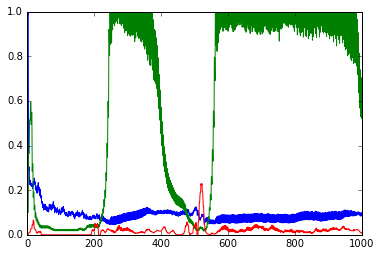

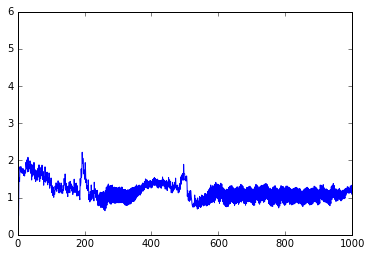

In [98]:
%matplotlib inline
from matplotlib import pyplot as pl
pl.plot([f / max(average_food) for f in average_food], label='Average food')
pl.plot([min(p, MAX_POP_SIZE) / MAX_POP_SIZE for p in population_size], label='Population size')
pl.plot(average_childlessness, label='Average childlessness')
#pl.legend()
pl.show()
pl.plot([f / av for f, av in zip(average_init_to_children, average_food)], label='Average child start food')
pl.show()

In [99]:
INITIAL_FOOD = 10
AVERAGE_FOOD = 1
INITIAL_POPULATION_SIZE = 50
MAX_POP_SIZE = 500
ITERATIONS = 1000

genomes = random_genome(allow_childless=False)
population = [Person(next(genomes), 100, False) for __ in xrange(INITIAL_POPULATION_SIZE)]

average_childlessness = [0.0]
average_food = [INITIAL_FOOD]
population_size = [INITIAL_POPULATION_SIZE]
average_init_to_children = [sum(p.genome[Person.INIT_TO_CHILDREN] for p in population) / INITIAL_POPULATION_SIZE]
average_amount_to_self = [sum(p.genome[Person.PERCENT_TO_SELF] for p in population) / INITIAL_POPULATION_SIZE]
for iteration in xrange(ITERATIONS):
    for person in population:
        person.step(random.gauss(AVERAGE_FOOD, 1), population)
    living_pop = [person for person in population if not person.dead]
    if not living_pop:
        print 'All dead!'
        break
    num_living = len(living_pop)
    population_size.append(num_living)
    average_childlessness.append(sum(
        person.genome[Person.CHANCE_CHILDLESS_CHILD]
        for person in living_pop
    ) / num_living)
    average_food.append(sum(
        person.food
        for person in living_pop
    ) / num_living)
    average_init_to_children.append(sum(
        person.genome[Person.INIT_TO_CHILDREN] 
        for person in living_pop
    ) / num_living)
    average_amount_to_self.append(sum(
        person.genome[Person.PERCENT_TO_SELF] 
        for person in living_pop
    ) / num_living)
    if not (iteration + 1) % 25:
        print iteration + 1, num_living, average_childlessness[-1], average_food[-1]
    if num_living > MAX_POP_SIZE:
        least_fit = sorted(population, key=attrgetter('food'))[:num_living - MAX_POP_SIZE]
        for person in least_fit:
            person.dead = True
    for person in population[:]:
        if person.dead:
            population.remove(person)

25 1819 0.0119385897783 2.81170921923
50 511 0.0344128468309 5.45765470669
75 484 0.0383426575849 6.37486314842
100 1651 0.0216769194002 2.99521174018
125 500 0.0487534491195 6.60140228051
150 484 0.0328146189393 6.967182948
175 1308 0.026058076817 3.69822354931
200 500 0.0521797953019 7.33161631099
225 484 0.0250158270515 8.02656304521
250 892 0.0290457487174 5.79598070793
275 500 0.0241995382638 10.5183887539
300 421 0.0244987150146 10.4039520905
325 677 0.0191319307856 7.76165115612
350 500 0.03163789495 10.9991892621
375 397 0.0182537236613 9.63727773144
400 662 0.0282378791339 7.40222059467
425 500 0.0273162566298 8.89738143437
450 467 0.0163144068906 9.12145648968
475 934 0.0297652289161 5.69321885004
500 500 0.0366703752037 9.10683366899
525 457 0.0330480237724 9.40600389746
550 1009 0.0156654420893 5.19011240751
575 500 0.0281936428487 9.52635854891
600 439 0.0485027013735 10.2704554321
625 838 0.021928649317 6.3290736724
650 500 0.0411903892238 9.44104838383
675 459 0.02226690

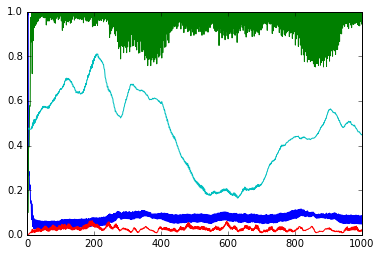

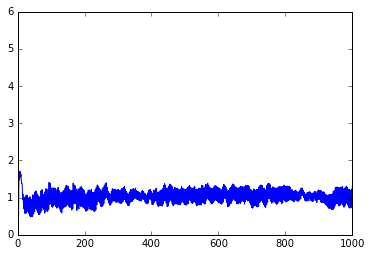

In [100]:
%matplotlib inline
from matplotlib import pyplot as pl
pl.plot([f / max(average_food) for f in average_food], label='Average food')
pl.plot([min(p, MAX_POP_SIZE) / MAX_POP_SIZE for p in population_size], label='Population size')
pl.plot(average_childlessness, label='Average childlessness')
pl.plot(average_amount_to_self, label='Amount to self')
#pl.legend()
pl.show()
pl.plot([f / av for f, av in zip(average_init_to_children, average_food)], label='Average child start food')
pl.show()

25 984 0.0132725493476 4.54610722507
50 500 0.0193677207715 8.09724677764
75 472 0.0156544229924 8.79423375158
100 1036 0.0224014569514 5.12641047849
125 500 0.0197172326559 8.0775053629
150 470 0.0293899184847 9.15296541594
175 965 0.0142222053685 5.60533893306
200 500 0.0144665873217 9.63362539361
225 406 0.0232382723873 11.4039659909
250 782 0.00881774249498 6.8592160048
275 500 0.0170488787794 9.80677616959
300 448 0.0241818591218 10.450528028
325 755 0.0335120550643 7.60413604713
350 500 0.06464821622 10.8836620581
375 375 0.0446692146609 10.2398839261
400 642 0.0107870960307 6.54471948214
425 500 0.0375370406206 9.14837917766
450 475 0.0346092265486 8.9941816263
475 932 0.0199189394548 5.60624016008
500 500 0.0163423935958 8.80736566504
525 443 0.0284153853682 10.4235673226
550 984 0.00871632152078 5.46943132336
575 500 0.0364607512336 8.97238534752
600 444 0.0324975457493 9.9787766112
625 988 0.0105515870566 5.4554546892
650 500 0.0248720018642 8.26859170288
675 461 0.0359319990

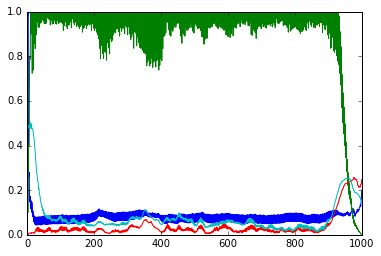

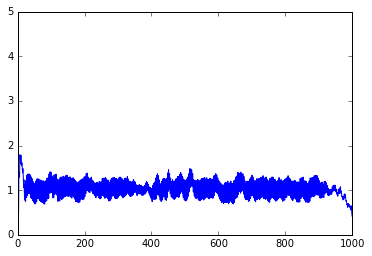

In [103]:
INITIAL_FOOD = 10
AVERAGE_FOOD = 1
INITIAL_POPULATION_SIZE = 50
MAX_POP_SIZE = 500
ITERATIONS = 1000

genomes = random_genome(allow_childless=False)
population = [Person(next(genomes), 100, False) for __ in xrange(INITIAL_POPULATION_SIZE)]

average_childlessness = [0.0]
average_food = [INITIAL_FOOD]
population_size = [INITIAL_POPULATION_SIZE]
average_init_to_children = [sum(p.genome[Person.INIT_TO_CHILDREN] for p in population) / INITIAL_POPULATION_SIZE]
average_amount_to_self = [sum(p.genome[Person.PERCENT_TO_SELF] for p in population) / INITIAL_POPULATION_SIZE]
for iteration in xrange(ITERATIONS):
    for person in population:
        person.step(random.gauss(AVERAGE_FOOD, 1), population)
    living_pop = [person for person in population if not person.dead]
    if not living_pop:
        print 'All dead!'
        break
    num_living = len(living_pop)
    population_size.append(num_living)
    average_childlessness.append(sum(
        person.genome[Person.CHANCE_CHILDLESS_CHILD]
        for person in living_pop
    ) / num_living)
    average_food.append(sum(
        person.food
        for person in living_pop
    ) / num_living)
    average_init_to_children.append(sum(
        person.genome[Person.INIT_TO_CHILDREN] 
        for person in living_pop
    ) / num_living)
    average_amount_to_self.append(sum(
        person.genome[Person.PERCENT_TO_SELF] 
        for person in living_pop
    ) / num_living)
    if not (iteration + 1) % 25:
        print iteration + 1, num_living, average_childlessness[-1], average_food[-1]
    if num_living > MAX_POP_SIZE:
        least_fit = sorted(population, key=attrgetter('food'))[:num_living - MAX_POP_SIZE]
        for person in least_fit:
            person.dead = True
    for person in population[:]:
        if person.dead:
            population.remove(person)
            
%matplotlib inline
from matplotlib import pyplot as pl
pl.plot([f / max(average_food) for f in average_food], label='Average food')
pl.plot([min(p, MAX_POP_SIZE) / MAX_POP_SIZE for p in population_size], label='Population size')
pl.plot(average_childlessness, label='Average childlessness')
pl.plot(average_amount_to_self, label='Amount to self')
#pl.legend()
pl.show()
pl.plot([f / av for f, av in zip(average_init_to_children, average_food)], label='Average child start food')
pl.show()

25 90 1.15429480775e-05 17.1597331221
50 50 0.0214673926323 10.6612539221
75 23 0.00297030843921 9.6055441166
100 30 0.0242084311456 8.8938417892
125 25 0.0189997043666 8.81215154554
150 28 3.27264128909e-06 8.63040680523
175 698 0.0209456326381 5.55038077881
200 500 0.0241640669456 8.08609359686
225 463 0.0339944424902 9.47150065043
250 744 0.0339832159231 7.29681245454
275 500 0.0163703879848 10.5044428682
300 375 0.0156158300678 10.443385295
325 439 0.00811349143667 8.24422544636
350 273 0.0190755164332 9.48057500427
375 101 0.0142741740995 9.72121616189
400 233 0.0193578446032 6.14644401728
425 500 0.0173851749962 8.024087325
450 466 0.0322913184292 9.220949133
475 1013 0.0166454369712 5.01207804442
500 500 0.0217918421614 8.67997991249
525 460 0.0284614661947 10.574134931
550 815 0.0145109471837 6.80587912582
575 500 0.0291591894085 10.0599893293
600 453 0.0608374581466 10.8336058431
625 741 0.0344475776492 7.53048659148
650 500 0.0328352813707 10.6158975095
675 393 0.022099077276

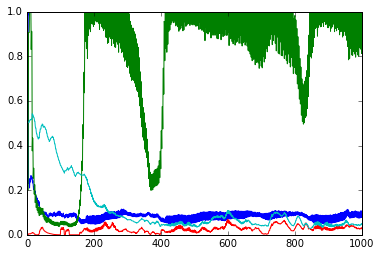

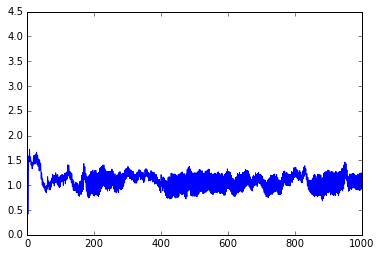

In [122]:
INITIAL_FOOD = 10
AVERAGE_FOOD = 1
INITIAL_POPULATION_SIZE = 100
MAX_POP_SIZE = 500
ITERATIONS = 1000

genomes = random_genome(allow_childless=False)
population = [Person(next(genomes), 100, False) for __ in xrange(INITIAL_POPULATION_SIZE)]

average_childlessness = [0.0]
average_food = [INITIAL_FOOD]
population_size = [INITIAL_POPULATION_SIZE]
average_init_to_children = [sum(p.genome[Person.INIT_TO_CHILDREN] for p in population) / INITIAL_POPULATION_SIZE]
average_amount_to_self = [sum(p.genome[Person.PERCENT_TO_SELF] for p in population) / INITIAL_POPULATION_SIZE]
for iteration in xrange(ITERATIONS):
    for person in population:
        person.step(random.gauss(AVERAGE_FOOD, 1), population)
    living_pop = [person for person in population if not person.dead]
    if not living_pop:
        print 'All dead!'
        break
    num_living = len(living_pop)
    population_size.append(num_living)
    average_childlessness.append(sum(
        person.genome[Person.CHANCE_CHILDLESS_CHILD]
        for person in living_pop
    ) / num_living)
    average_food.append(sum(
        person.food
        for person in living_pop
    ) / num_living)
    average_init_to_children.append(sum(
        person.genome[Person.INIT_TO_CHILDREN] 
        for person in living_pop
    ) / num_living)
    average_amount_to_self.append(sum(
        person.genome[Person.PERCENT_TO_SELF] 
        for person in living_pop
    ) / num_living)
    if not (iteration + 1) % 25:
        print iteration + 1, num_living, average_childlessness[-1], average_food[-1]
    if num_living > MAX_POP_SIZE:
        least_fit = sorted(population, key=attrgetter('food'))[:num_living - MAX_POP_SIZE]
        for person in least_fit:
            person.dead = True
    for person in population[:]:
        if person.dead:
            population.remove(person)
            
%matplotlib inline
from matplotlib import pyplot as pl
pl.plot([f / max(average_food) for f in average_food], label='Average food')
pl.plot([min(p, MAX_POP_SIZE) / MAX_POP_SIZE for p in population_size], label='Population size')
pl.plot(average_childlessness, label='Average childlessness')
pl.plot(average_amount_to_self, label='Amount to self')
#pl.legend()
pl.show()
pl.plot([f / av for f, av in zip(average_init_to_children, average_food)], label='Average child start food')
pl.show()

25 221 0.00771655958004 10.7651345096
50 214 0.0194973723336 8.67374406169
75 124 0.0014463656079 9.90808903822
100 156 0.00299803427669 7.1761603084
125 246 0.0083213038523 8.20343159975
150 194 0.0238058934937 9.03383736322
175 174 0.0313369361295 8.64514216311
200 138 0.00891200458624 9.34871259623
225 66 0.0185226184714 9.92942375529
250 439 0.0209653282343 5.46428149903
275 500 0.0339645500325 8.93263047473
300 469 0.0297961296556 9.04450029233
325 980 0.0294027678697 5.30183829956
350 500 0.0354474610437 8.29012177803
375 457 0.023488020178 9.13086064513
400 991 0.0228367395332 5.36104942368
425 500 0.0596664296591 8.98025249791
450 439 0.0290553673144 9.20620922592
475 932 0.0205852657849 5.62279923197
500 500 0.0237852825143 9.36445973072
525 444 0.0272885875091 10.4147683501
550 826 0.0166611914113 6.79997264288
575 500 0.026452678522 11.3823079289
600 393 0.0161063248595 11.6786652765
625 593 0.010116618039 7.76266653924
650 500 0.0267116723942 9.41375706408
675 439 0.0283872

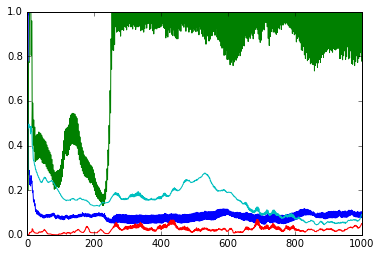

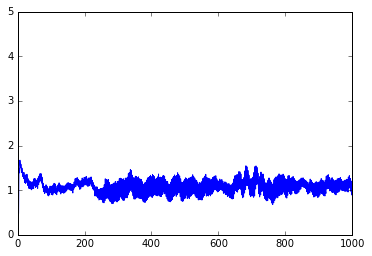

In [129]:
INITIAL_FOOD = 10
AVERAGE_FOOD = 1
INITIAL_POPULATION_SIZE = 100
MAX_POP_SIZE = 500
ITERATIONS = 1000

genomes = random_genome(allow_childless=False)
population = [Person(next(genomes), 100, False) for __ in xrange(INITIAL_POPULATION_SIZE)]

average_childlessness = [0.0]
average_food = [INITIAL_FOOD]
population_size = [INITIAL_POPULATION_SIZE]
average_init_to_children = [sum(p.genome[Person.INIT_TO_CHILDREN] for p in population) / INITIAL_POPULATION_SIZE]
average_amount_to_self = [sum(p.genome[Person.PERCENT_TO_SELF] for p in population) / INITIAL_POPULATION_SIZE]
for iteration in xrange(ITERATIONS):
    for person in population:
        person.step(random.gauss(AVERAGE_FOOD, 1), population)
    living_pop = [person for person in population if not person.dead]
    if not living_pop:
        print 'All dead!'
        break
    num_living = len(living_pop)
    population_size.append(num_living)
    average_childlessness.append(sum(
        person.genome[Person.CHANCE_CHILDLESS_CHILD]
        for person in living_pop
    ) / num_living)
    average_food.append(sum(
        person.food
        for person in living_pop
    ) / num_living)
    average_init_to_children.append(sum(
        person.genome[Person.INIT_TO_CHILDREN] 
        for person in living_pop
    ) / num_living)
    average_amount_to_self.append(sum(
        person.genome[Person.PERCENT_TO_SELF] 
        for person in living_pop
    ) / num_living)
    if not (iteration + 1) % 25:
        print iteration + 1, num_living, average_childlessness[-1], average_food[-1]
    if num_living > MAX_POP_SIZE:
        least_fit = sorted(population, key=attrgetter('food'))[:num_living - MAX_POP_SIZE]
        for person in least_fit:
            person.dead = True
    for person in population[:]:
        if person.dead:
            population.remove(person)
            
%matplotlib inline
from matplotlib import pyplot as pl
pl.plot([f / max(average_food) for f in average_food], label='Average food')
pl.plot([min(p, MAX_POP_SIZE) / MAX_POP_SIZE for p in population_size], label='Population size')
pl.plot(average_childlessness, label='Average childlessness')
pl.plot(average_amount_to_self, label='Amount to self')
#pl.legend()
pl.show()
pl.plot([f / av for f, av in zip(average_init_to_children, average_food)], label='Average child start food')
pl.show()

25 180 0.0568096233351 14.084634732
50 91 0.0115132224963 11.5816729867
75 51 0.00247698341721 10.474580962
100 61 7.4989138378e-06 7.97382675229
125 90 8.36843402412e-07 7.18545215043
150 304 0.00546850188346 8.16138608868
175 664 0.02143642284 7.63956374252
200 500 0.0189621485382 10.0667096663
225 432 0.0175929053215 9.98747984504
250 772 0.0145976485198 7.30718727503
275 500 0.0153546267262 11.1457061459
300 434 0.0112282212972 9.92995554092
325 909 0.0129128491568 6.15476609158
350 500 0.0267757623737 10.2758043089
375 417 0.0194114499958 10.9990765874
400 685 0.0356546100755 7.54483221097
425 500 0.0178145898945 10.8004263275
450 380 0.0409721143662 10.5946115787
475 541 0.0361977258222 7.66751922175
500 500 0.0237647443271 9.38135849246
525 432 0.0133176088524 9.37823793714
550 791 0.0348487243904 6.70450179355
575 500 0.0283449250167 9.02748914527
600 459 0.0313467968749 10.1478045311
625 807 0.0288165007217 6.95214533143
650 500 0.0268705862493 10.4480350231
675 455 0.03485567

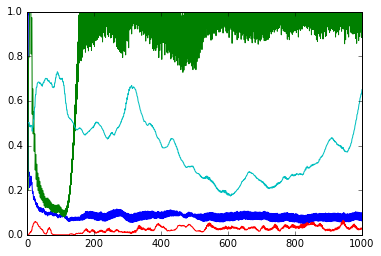

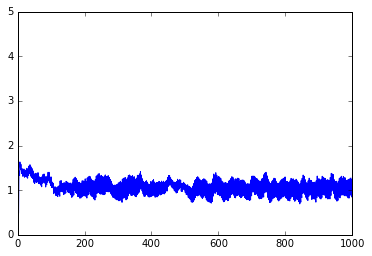

In [131]:
INITIAL_FOOD = 10
AVERAGE_FOOD = 1
INITIAL_POPULATION_SIZE = 100
MAX_POP_SIZE = 500
ITERATIONS = 1000

genomes = random_genome(allow_childless=False)
population = [Person(next(genomes), 100, False) for __ in xrange(INITIAL_POPULATION_SIZE)]

average_childlessness = [0.0]
average_food = [INITIAL_FOOD]
population_size = [INITIAL_POPULATION_SIZE]
average_init_to_children = [sum(p.genome[Person.INIT_TO_CHILDREN] for p in population) / INITIAL_POPULATION_SIZE]
average_amount_to_self = [sum(p.genome[Person.PERCENT_TO_SELF] for p in population) / INITIAL_POPULATION_SIZE]
for iteration in xrange(ITERATIONS):
    for person in population:
        person.step(random.gauss(AVERAGE_FOOD, 1), population)
    living_pop = [person for person in population if not person.dead]
    if not living_pop:
        print 'All dead!'
        break
    num_living = len(living_pop)
    population_size.append(num_living)
    average_childlessness.append(sum(
        person.genome[Person.CHANCE_CHILDLESS_CHILD]
        for person in living_pop
    ) / num_living)
    average_food.append(sum(
        person.food
        for person in living_pop
    ) / num_living)
    average_init_to_children.append(sum(
        person.genome[Person.INIT_TO_CHILDREN] 
        for person in living_pop
    ) / num_living)
    average_amount_to_self.append(sum(
        person.genome[Person.PERCENT_TO_SELF] 
        for person in living_pop
    ) / num_living)
    if not (iteration + 1) % 25:
        print iteration + 1, num_living, average_childlessness[-1], average_food[-1]
    if num_living > MAX_POP_SIZE:
        least_fit = sorted(population, key=attrgetter('food'))[:num_living - MAX_POP_SIZE]
        for person in least_fit:
            person.dead = True
    for person in population[:]:
        if person.dead:
            population.remove(person)
            
%matplotlib inline
from matplotlib import pyplot as pl
pl.plot([f / max(average_food) for f in average_food], label='Average food')
pl.plot([min(p, MAX_POP_SIZE) / MAX_POP_SIZE for p in population_size], label='Population size')
pl.plot(average_childlessness, label='Average childlessness')
pl.plot(average_amount_to_self, label='Amount to self')
#pl.legend()
pl.show()
pl.plot([f / av for f, av in zip(average_init_to_children, average_food)], label='Average child start food')
pl.show()

25 109 0.00760330951083 16.2560591277
50 43 0.0 12.0053268936
75 18 0.0 10.6575501627
100 36 0.00791715965644 8.15116904936
125 26 0.00205952233905 8.06254952675
150 141 0.0134582042496 7.76476376693
175 675 0.027113320983 6.35665959949
200 500 0.0319801019395 9.02955760932
225 478 0.0292625413073 8.51851562477
250 1100 0.0110371589045 4.72676353054
275 500 0.0571767874541 8.64993556628
300 444 0.0528162545482 10.1877693122
325 940 0.0122360954191 5.30402576627
350 500 0.0127602953173 9.08411865315
375 463 0.0247225566866 10.2854506068
400 821 0.0412862223791 6.80791849839
425 500 0.0600473244101 9.79985094343
450 434 0.0817589422032 9.16916363116
475 894 0.0965203289698 5.57402989843
500 500 0.0995563160644 8.9278003842
525 423 0.0983159753348 9.92553966567
550 640 0.0871334692565 7.16877010377
575 500 0.0976472802801 9.67331775763
600 434 0.0950216242686 10.1912672792
625 744 0.0697262927638 6.87993597337
650 500 0.101691800905 9.58190740382
675 397 0.112711884886 9.81442717898
700 7

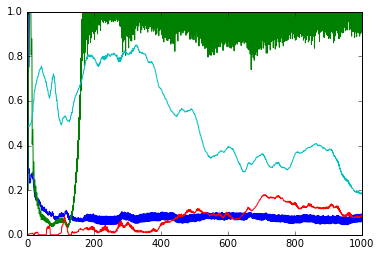

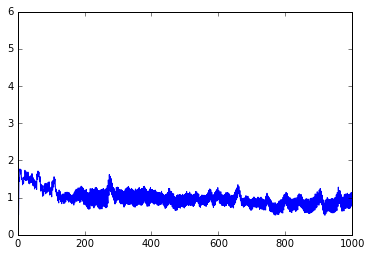

In [132]:
INITIAL_FOOD = 10
AVERAGE_FOOD = 1
INITIAL_POPULATION_SIZE = 100
MAX_POP_SIZE = 500
ITERATIONS = 1000

genomes = random_genome(allow_childless=False)
population = [Person(next(genomes), 100, False) for __ in xrange(INITIAL_POPULATION_SIZE)]

average_childlessness = [0.0]
average_food = [INITIAL_FOOD]
population_size = [INITIAL_POPULATION_SIZE]
average_init_to_children = [sum(p.genome[Person.INIT_TO_CHILDREN] for p in population) / INITIAL_POPULATION_SIZE]
average_amount_to_self = [sum(p.genome[Person.PERCENT_TO_SELF] for p in population) / INITIAL_POPULATION_SIZE]
for iteration in xrange(ITERATIONS):
    for person in population:
        person.step(random.gauss(AVERAGE_FOOD, 1), population)
    living_pop = [person for person in population if not person.dead]
    if not living_pop:
        print 'All dead!'
        break
    num_living = len(living_pop)
    population_size.append(num_living)
    average_childlessness.append(sum(
        person.genome[Person.CHANCE_CHILDLESS_CHILD]
        for person in living_pop
    ) / num_living)
    average_food.append(sum(
        person.food
        for person in living_pop
    ) / num_living)
    average_init_to_children.append(sum(
        person.genome[Person.INIT_TO_CHILDREN] 
        for person in living_pop
    ) / num_living)
    average_amount_to_self.append(sum(
        person.genome[Person.PERCENT_TO_SELF] 
        for person in living_pop
    ) / num_living)
    if not (iteration + 1) % 25:
        print iteration + 1, num_living, average_childlessness[-1], average_food[-1]
    if num_living > MAX_POP_SIZE:
        least_fit = sorted(population, key=attrgetter('food'))[:num_living - MAX_POP_SIZE]
        for person in least_fit:
            person.dead = True
    for person in population[:]:
        if person.dead:
            population.remove(person)
            
%matplotlib inline
from matplotlib import pyplot as pl
pl.plot([f / max(average_food) for f in average_food], label='Average food')
pl.plot([min(p, MAX_POP_SIZE) / MAX_POP_SIZE for p in population_size], label='Population size')
pl.plot(average_childlessness, label='Average childlessness')
pl.plot(average_amount_to_self, label='Amount to self')
#pl.legend()
pl.show()
pl.plot([f / av for f, av in zip(average_init_to_children, average_food)], label='Average child start food')
pl.show()